## Notebook Imports

In [1]:
from IPython.display import display

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import os
import opendatasets as od

import math
import datetime

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

from pmdarima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import minmax_scale

from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_absolute_error
from lightgbm import LGBMRegressor
from lofo import LOFOImportance, Dataset, plot_importance

C:\Users\sande\AppData\Local\Programs\Python\Python311\Lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

#### Dataset1

In [3]:
url = 'https://www.kaggle.com/datasets/hiteshsoneji/historical-weather-data-for-indian-cities?select=delhi.csv'

od.download(url)

Skipping, found downloaded files in ".\historical-weather-data-for-indian-cities" (use force=True to force download)


In [4]:
dir = './historical-weather-data-for-indian-cities/'

os.listdir(dir)

['bengaluru.csv',
 'bombay.csv',
 'delhi.csv',
 'hyderabad.csv',
 'jaipur.csv',
 'kanpur.csv',
 'nagpur.csv',
 'pune.csv']

In [5]:
path = dir + 'delhi.csv'

data = pd.read_csv(path, encoding='latin-1')
data.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2009-01-01 00:00:00,22,9,0.0,8.7,4,1,31,10:11 AM,09:57 PM,...,14,19,0,50,0.0,1016,10,10,331,12
1,2009-01-01 01:00:00,22,9,0.0,8.7,4,1,31,10:11 AM,09:57 PM,...,13,21,0,51,0.0,1016,10,10,329,13
2,2009-01-01 02:00:00,22,9,0.0,8.7,4,1,31,10:11 AM,09:57 PM,...,12,22,0,52,0.0,1016,9,10,327,13
3,2009-01-01 03:00:00,22,9,0.0,8.7,4,1,31,10:11 AM,09:57 PM,...,11,23,0,54,0.0,1016,9,10,326,13
4,2009-01-01 04:00:00,22,9,0.0,8.7,4,1,31,10:11 AM,09:57 PM,...,11,21,2,52,0.0,1016,9,10,318,13


In [6]:
# Changing the data type to 'date_time' for the first column and setting it as the index

data['date_time'] = pd.to_datetime(data['date_time'])
data.index = data['date_time']

In [7]:
# Extracting few columns into a seperate dataframe

df = data.loc[:,['tempC', 'sunHour', 'precipMM', 'pressure']]
print(f'dataset shape (rows, columns) - {df.shape}')
df.head()

dataset shape (rows, columns) - (96432, 4)


,tempC,sunHour,precipMM,pressure
date_time,,,,
2009-01-01 00:00:00,10,8.7,0.0,1016
2009-01-01 01:00:00,10,8.7,0.0,1016
2009-01-01 02:00:00,9,8.7,0.0,1016
2009-01-01 03:00:00,9,8.7,0.0,1016
2009-01-01 04:00:00,9,8.7,0.0,1016


In [8]:
df.dtypes, df.index.dtype

(tempC         int64
 sunHour     float64
 precipMM    float64
 pressure      int64
 dtype: object,
 dtype('<M8[ns]'))

In [9]:
df.describe()

,tempC,sunHour,precipMM,pressure
count,96432.000000,96432.000000,96432.000000,96432.000000
mean,26.672484,11.213489,0.032072,1006.972333
std,8.917470,2.155831,0.287923,7.789316
min,0.000000,3.800000,0.000000,987.000000
25%,20.000000,8.700000,0.000000,1000.000000
50%,28.000000,11.600000,0.000000,1007.000000
75%,33.000000,13.200000,0.000000,1014.000000
max,51.000000,14.000000,17.600000,1025.000000


In [10]:
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2009-01-01 00:00:00', '2009-01-01 01:00:00',
               '2009-01-01 02:00:00', '2009-01-01 03:00:00',
               '2009-01-01 04:00:00', '2009-01-01 05:00:00',
               '2009-01-01 06:00:00', '2009-01-01 07:00:00',
               '2009-01-01 08:00:00', '2009-01-01 09:00:00',
               ...
               '2020-01-01 14:00:00', '2020-01-01 15:00:00',
               '2020-01-01 16:00:00', '2020-01-01 17:00:00',
               '2020-01-01 18:00:00', '2020-01-01 19:00:00',
               '2020-01-01 20:00:00', '2020-01-01 21:00:00',
               '2020-01-01 22:00:00', '2020-01-01 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=96432, freq=None)

#### Imputation

In [11]:
df.isnull().count()

tempC       96432
sunHour     96432
precipMM    96432
pressure    96432
dtype: int64

In [12]:
df.ffill(inplace=True)
df[df.isnull()].count()

tempC       0
sunHour     0
precipMM    0
pressure    0
dtype: int64

#### Carrying out tests for checking the seasonality and stationarity of the dataset.

Text(0, 0.5, 'Percent')

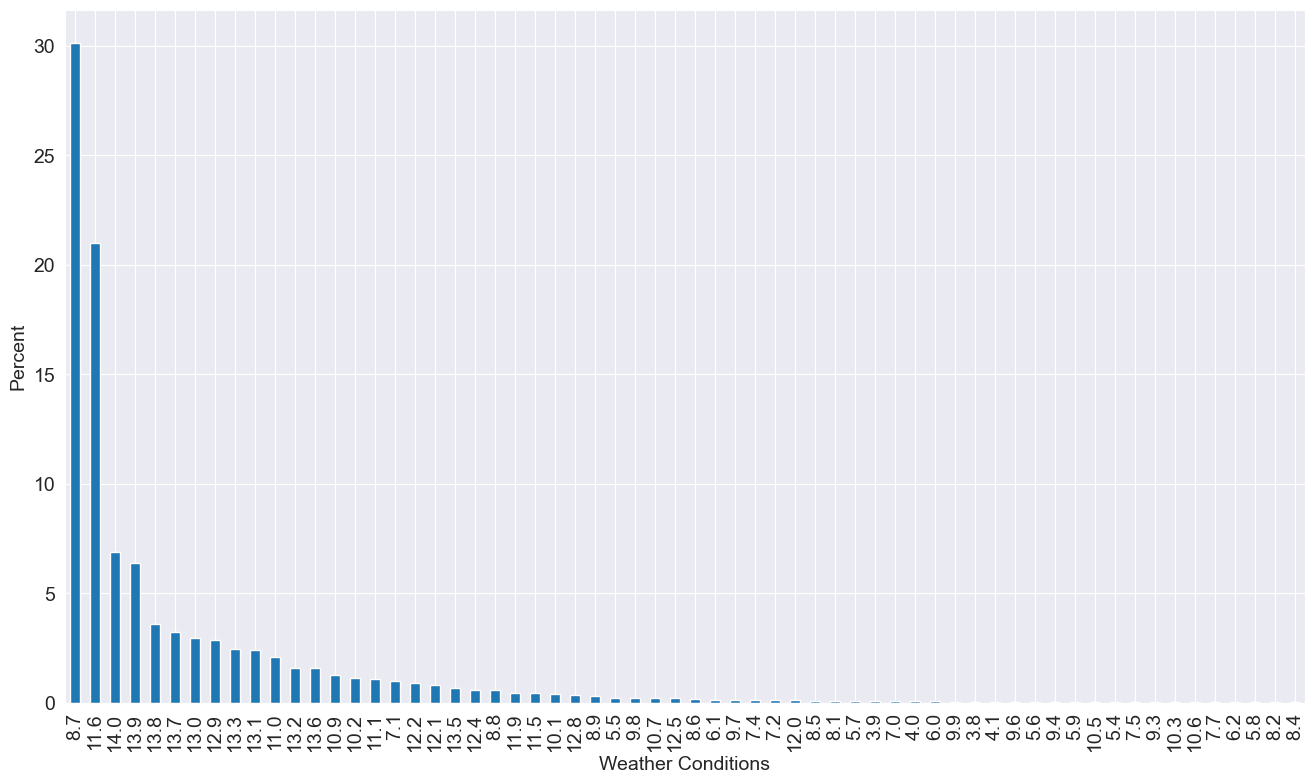

In [13]:
weather_condition = (df.sunHour.value_counts()/(df.sunHour.value_counts().sum()))*100
weather_condition.plot.bar(figsize=(16,9))
plt.xlabel('Weather Conditions')
plt.ylabel('Percent')

array([<Axes: xlabel='date_time'>, <Axes: xlabel='date_time'>,
       <Axes: xlabel='date_time'>, <Axes: xlabel='date_time'>],
      dtype=object)

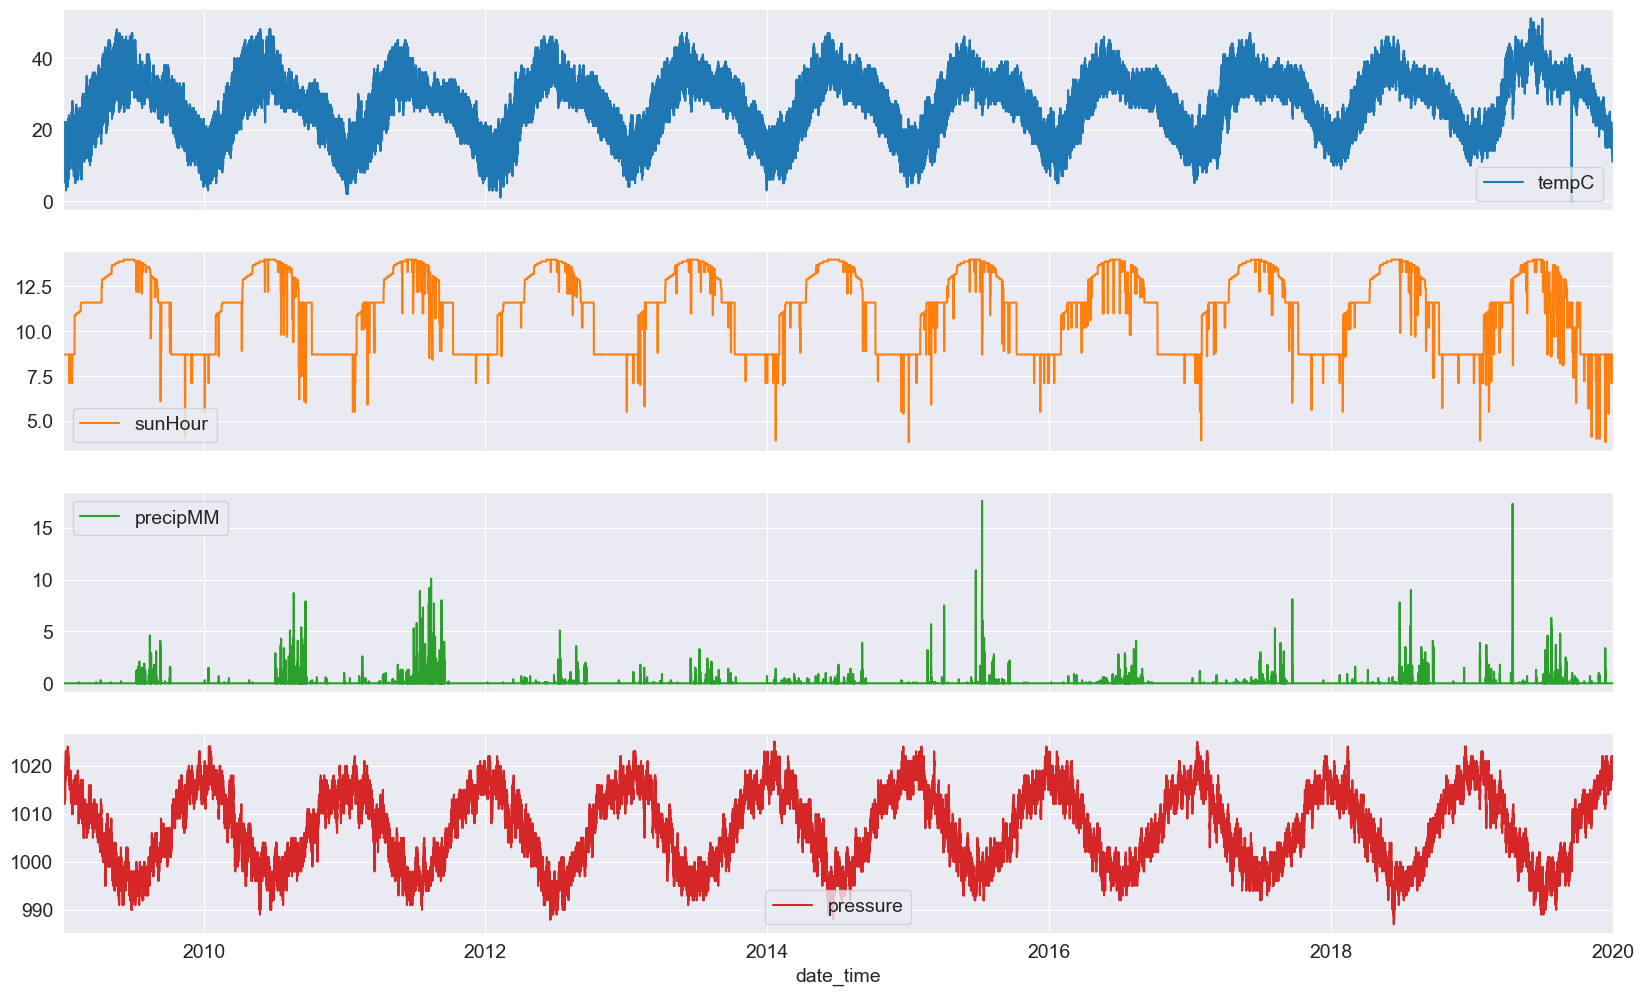

In [14]:
df.plot(subplots=True, figsize=(20,12))

array([<Axes: xlabel='date_time'>, <Axes: xlabel='date_time'>,
       <Axes: xlabel='date_time'>, <Axes: xlabel='date_time'>],
      dtype=object)

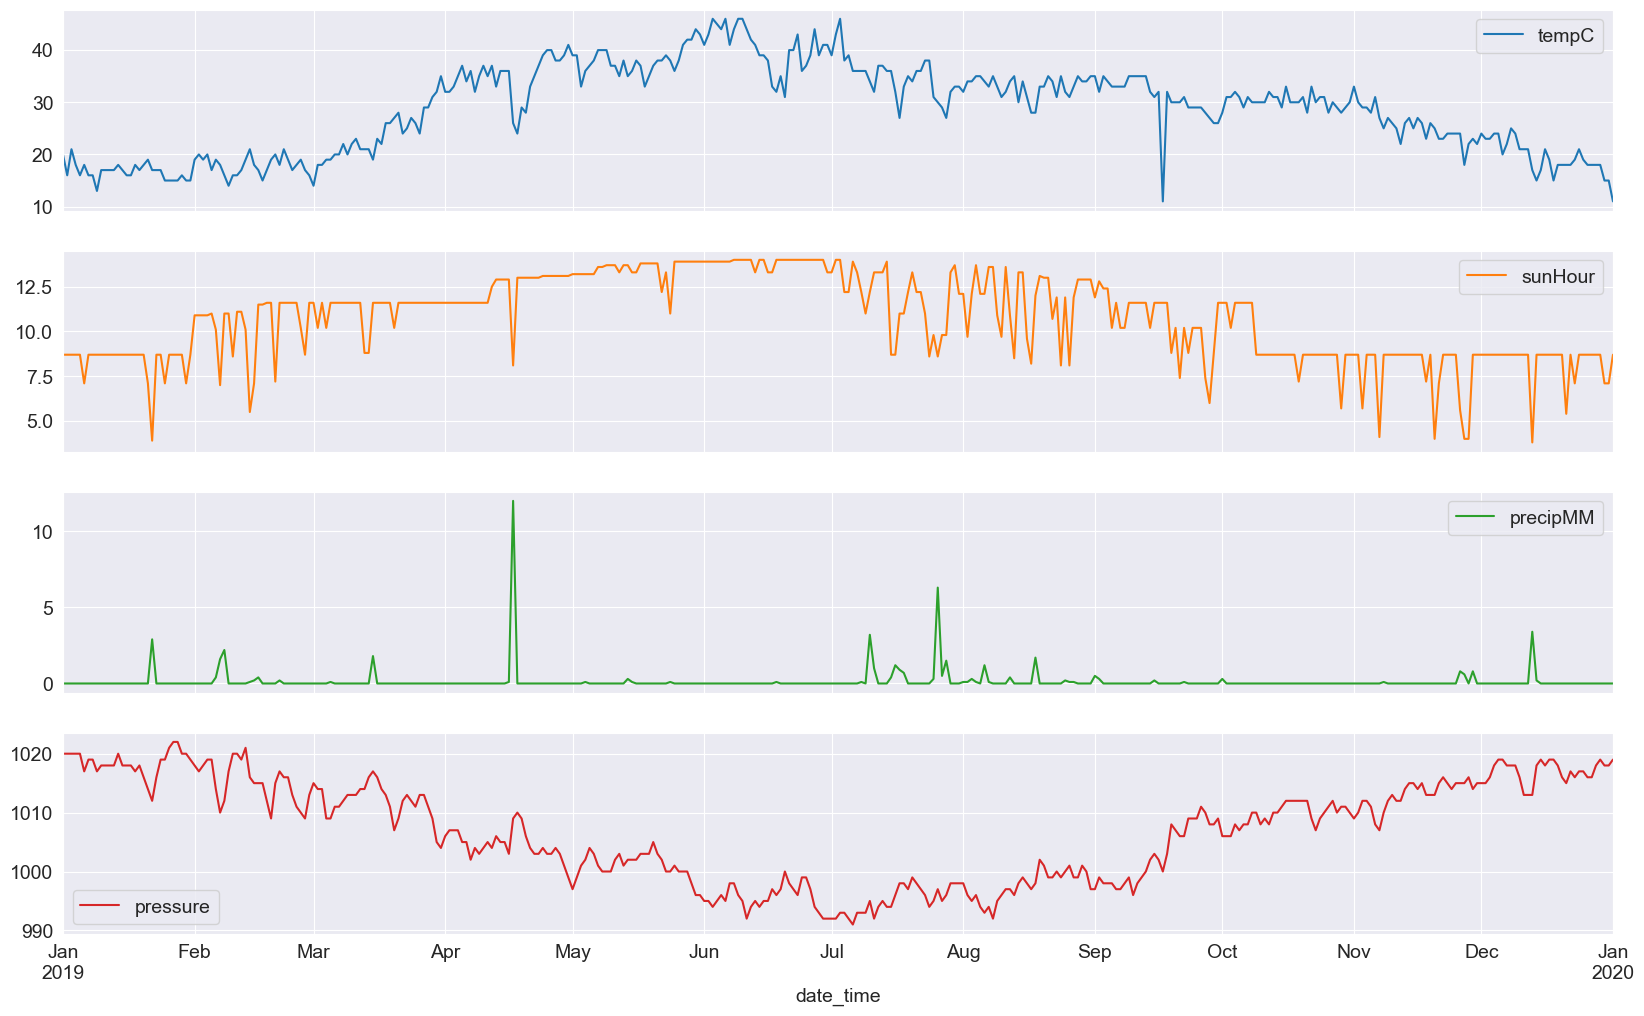

In [15]:
df['2019':'2020'].resample('D').fillna(method='pad').plot(subplots=True, figsize=(20,12))

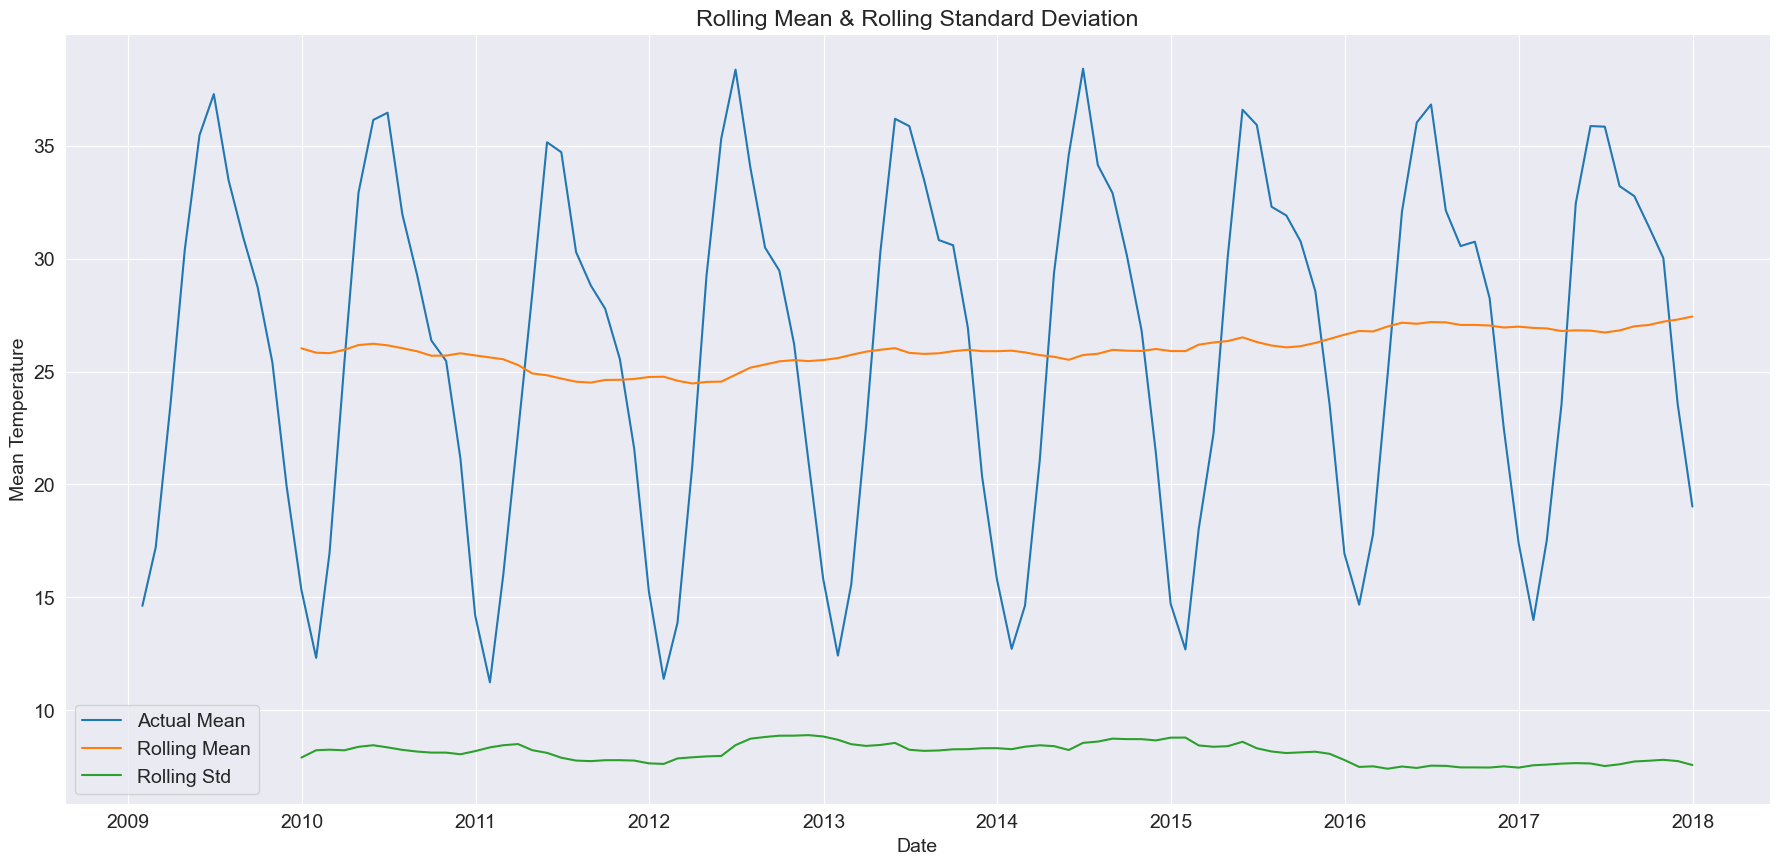

Test statistic:  -0.6395331177052929
Critical Values: {'1%': -3.5019123847798657, '5%': -2.892815255482889, '10%': -2.583453861475781}
P(rho) value 0.8617966602195372


In [16]:
# Dickey fuller test for checking stationarity

df = df.loc[:,['tempC']]

train_df = df['2009':'2017'].resample('M').mean().fillna(method='pad')
test_df = df['2017':'2020'].resample('M').mean().fillna(method='pad')

# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

def perform_dickey_fuller_test(ts):
#     result = adfuller(ts.iloc[:,0].values, autolag='AIC' )
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' ,result[4])
    print('P(rho) value', result[1])

plot_rolling_mean_std(train_df.tempC)
# plot_rolling_mean_std(train.sunHour)

perform_dickey_fuller_test(train_df.tempC)
# perform_dickey_fuller_test(train.sunHour)

Here, a 'rho' value of less than 1 indicates that the dataset in question is stationary.

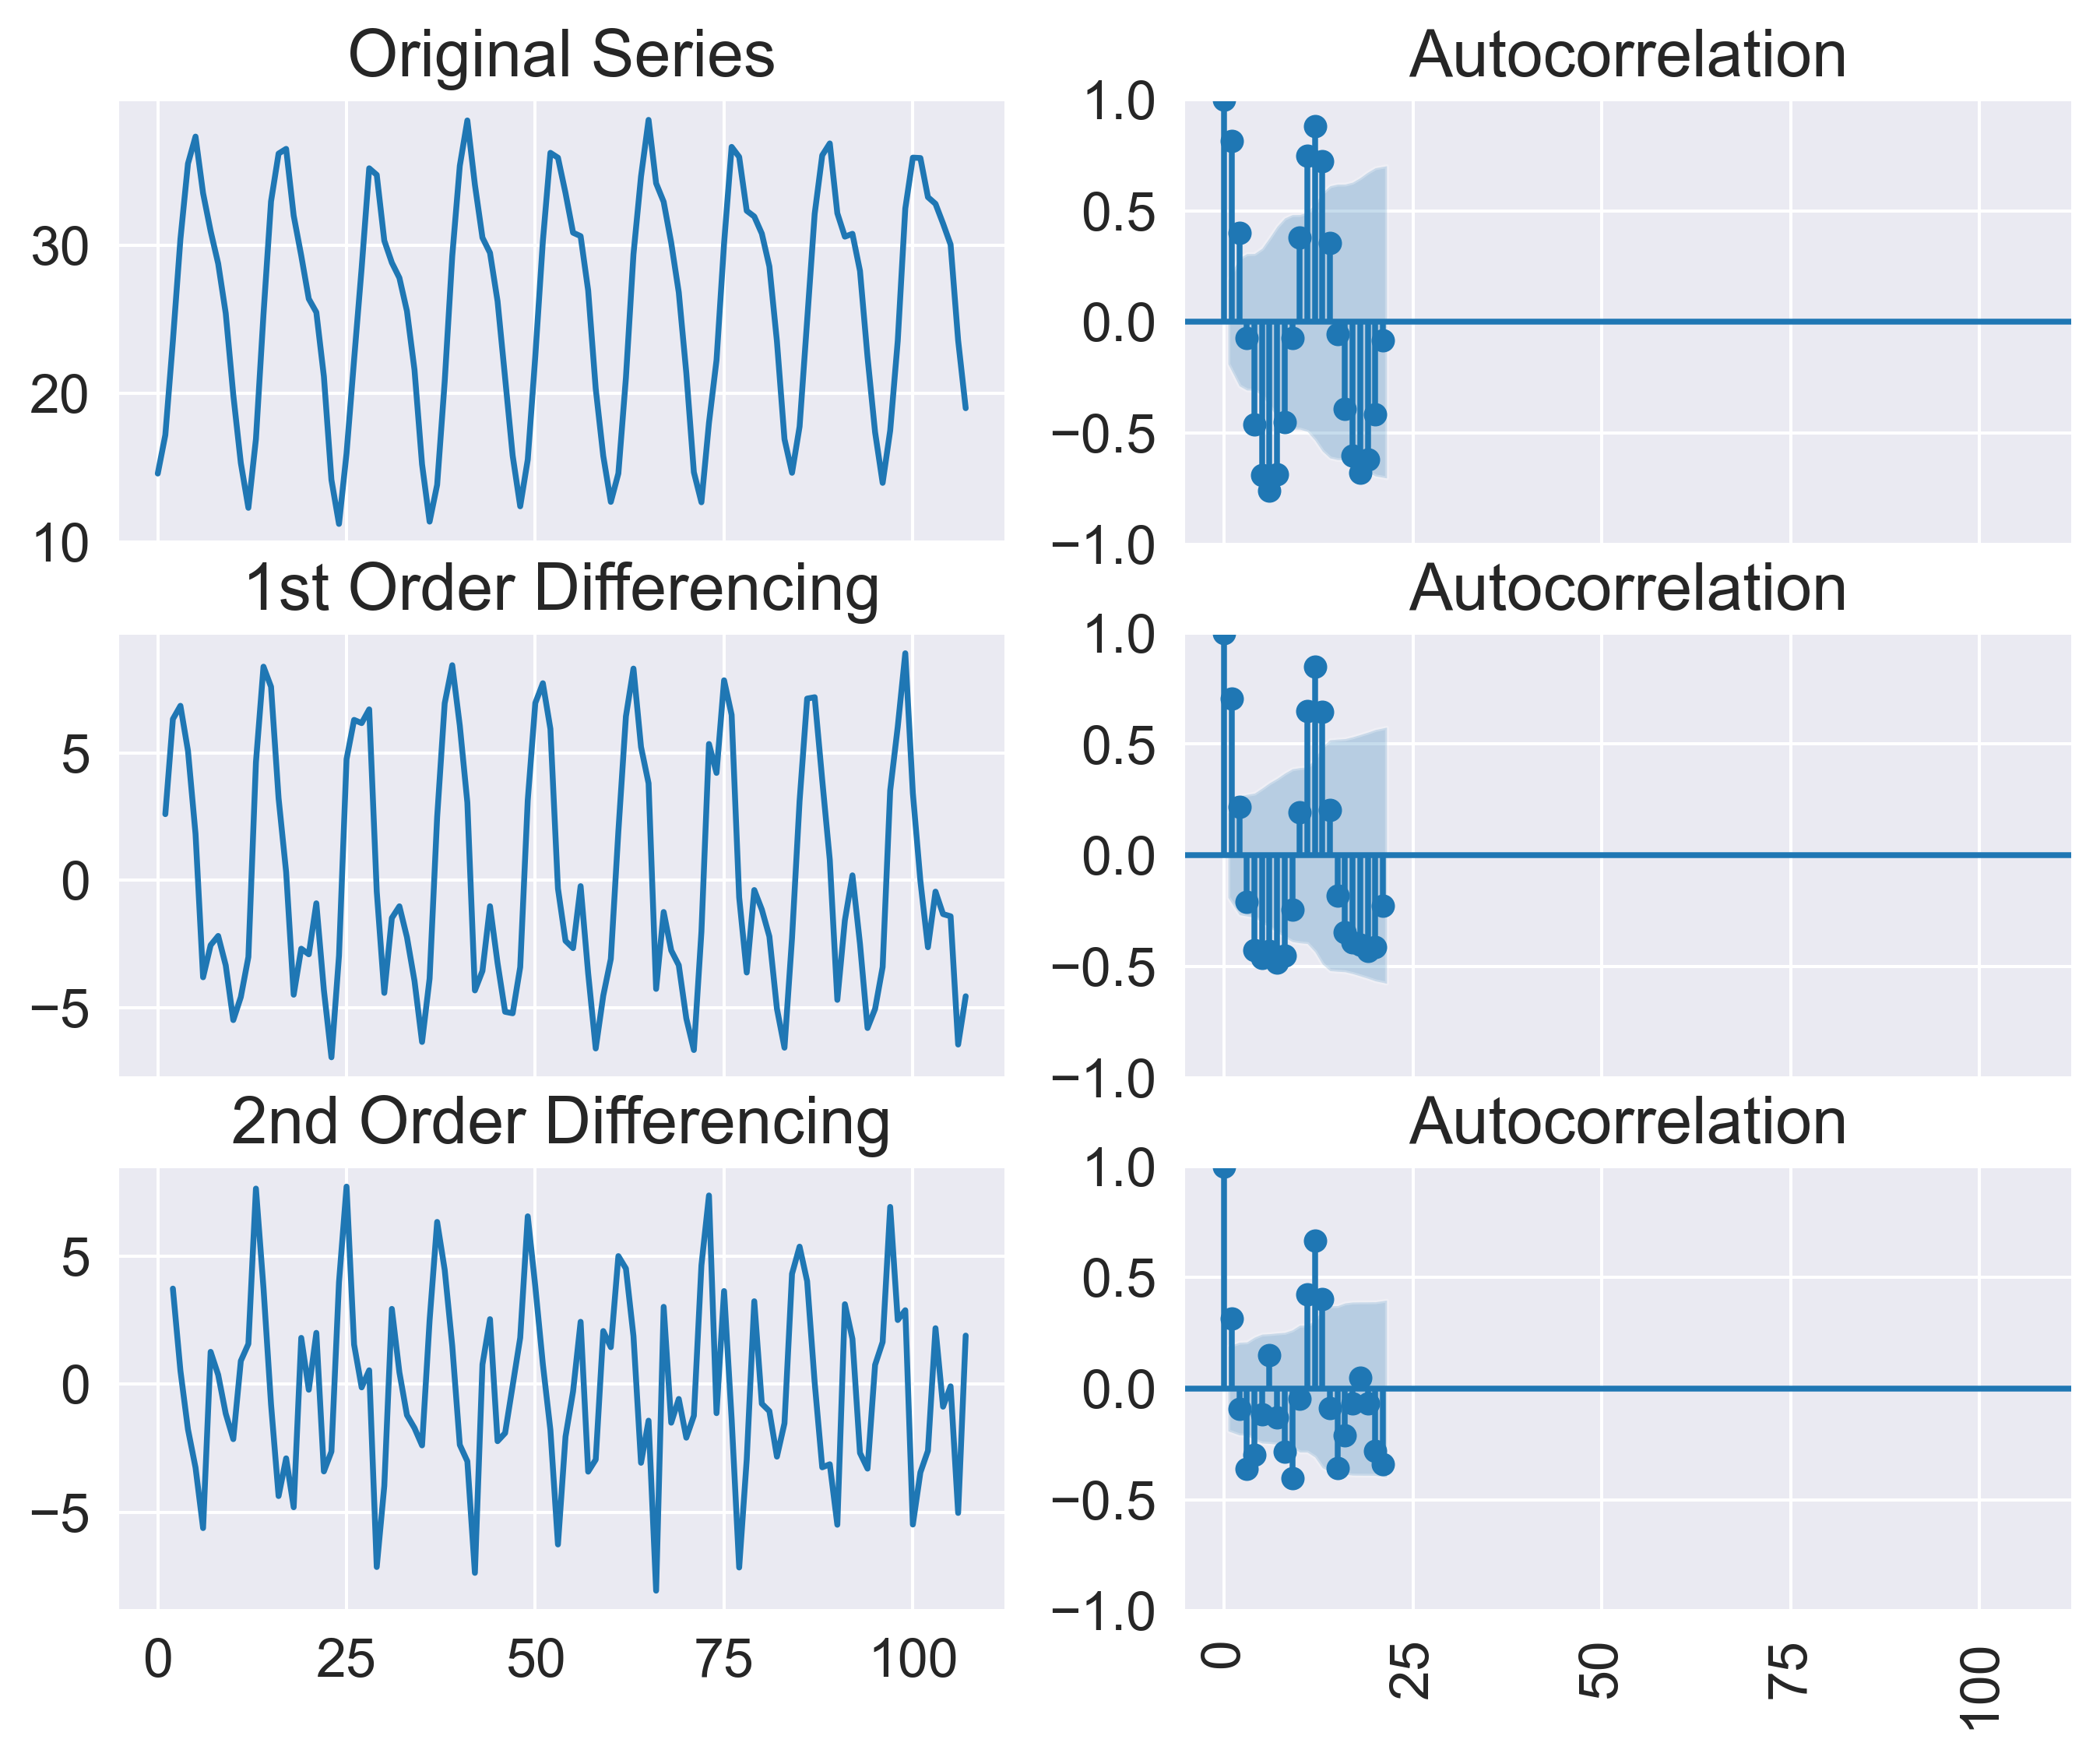

In [17]:
# Original Series
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':360})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train_df.values); 
axes[0, 0].set_title('Original Series')
plot_acf(train_df.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train_df.tempC.diff().values); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_df.diff().dropna().values,ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train_df.tempC.diff().diff().values); 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_df.diff().diff().dropna().values,ax=axes[2, 1])

plt.xticks(rotation='vertical')
plt.show()

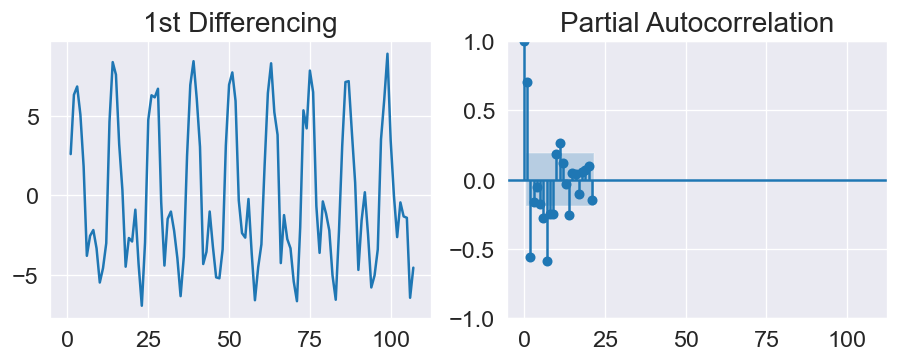

In [18]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_df.diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(train_df.diff().dropna().values, ax=axes[1])

plt.show()

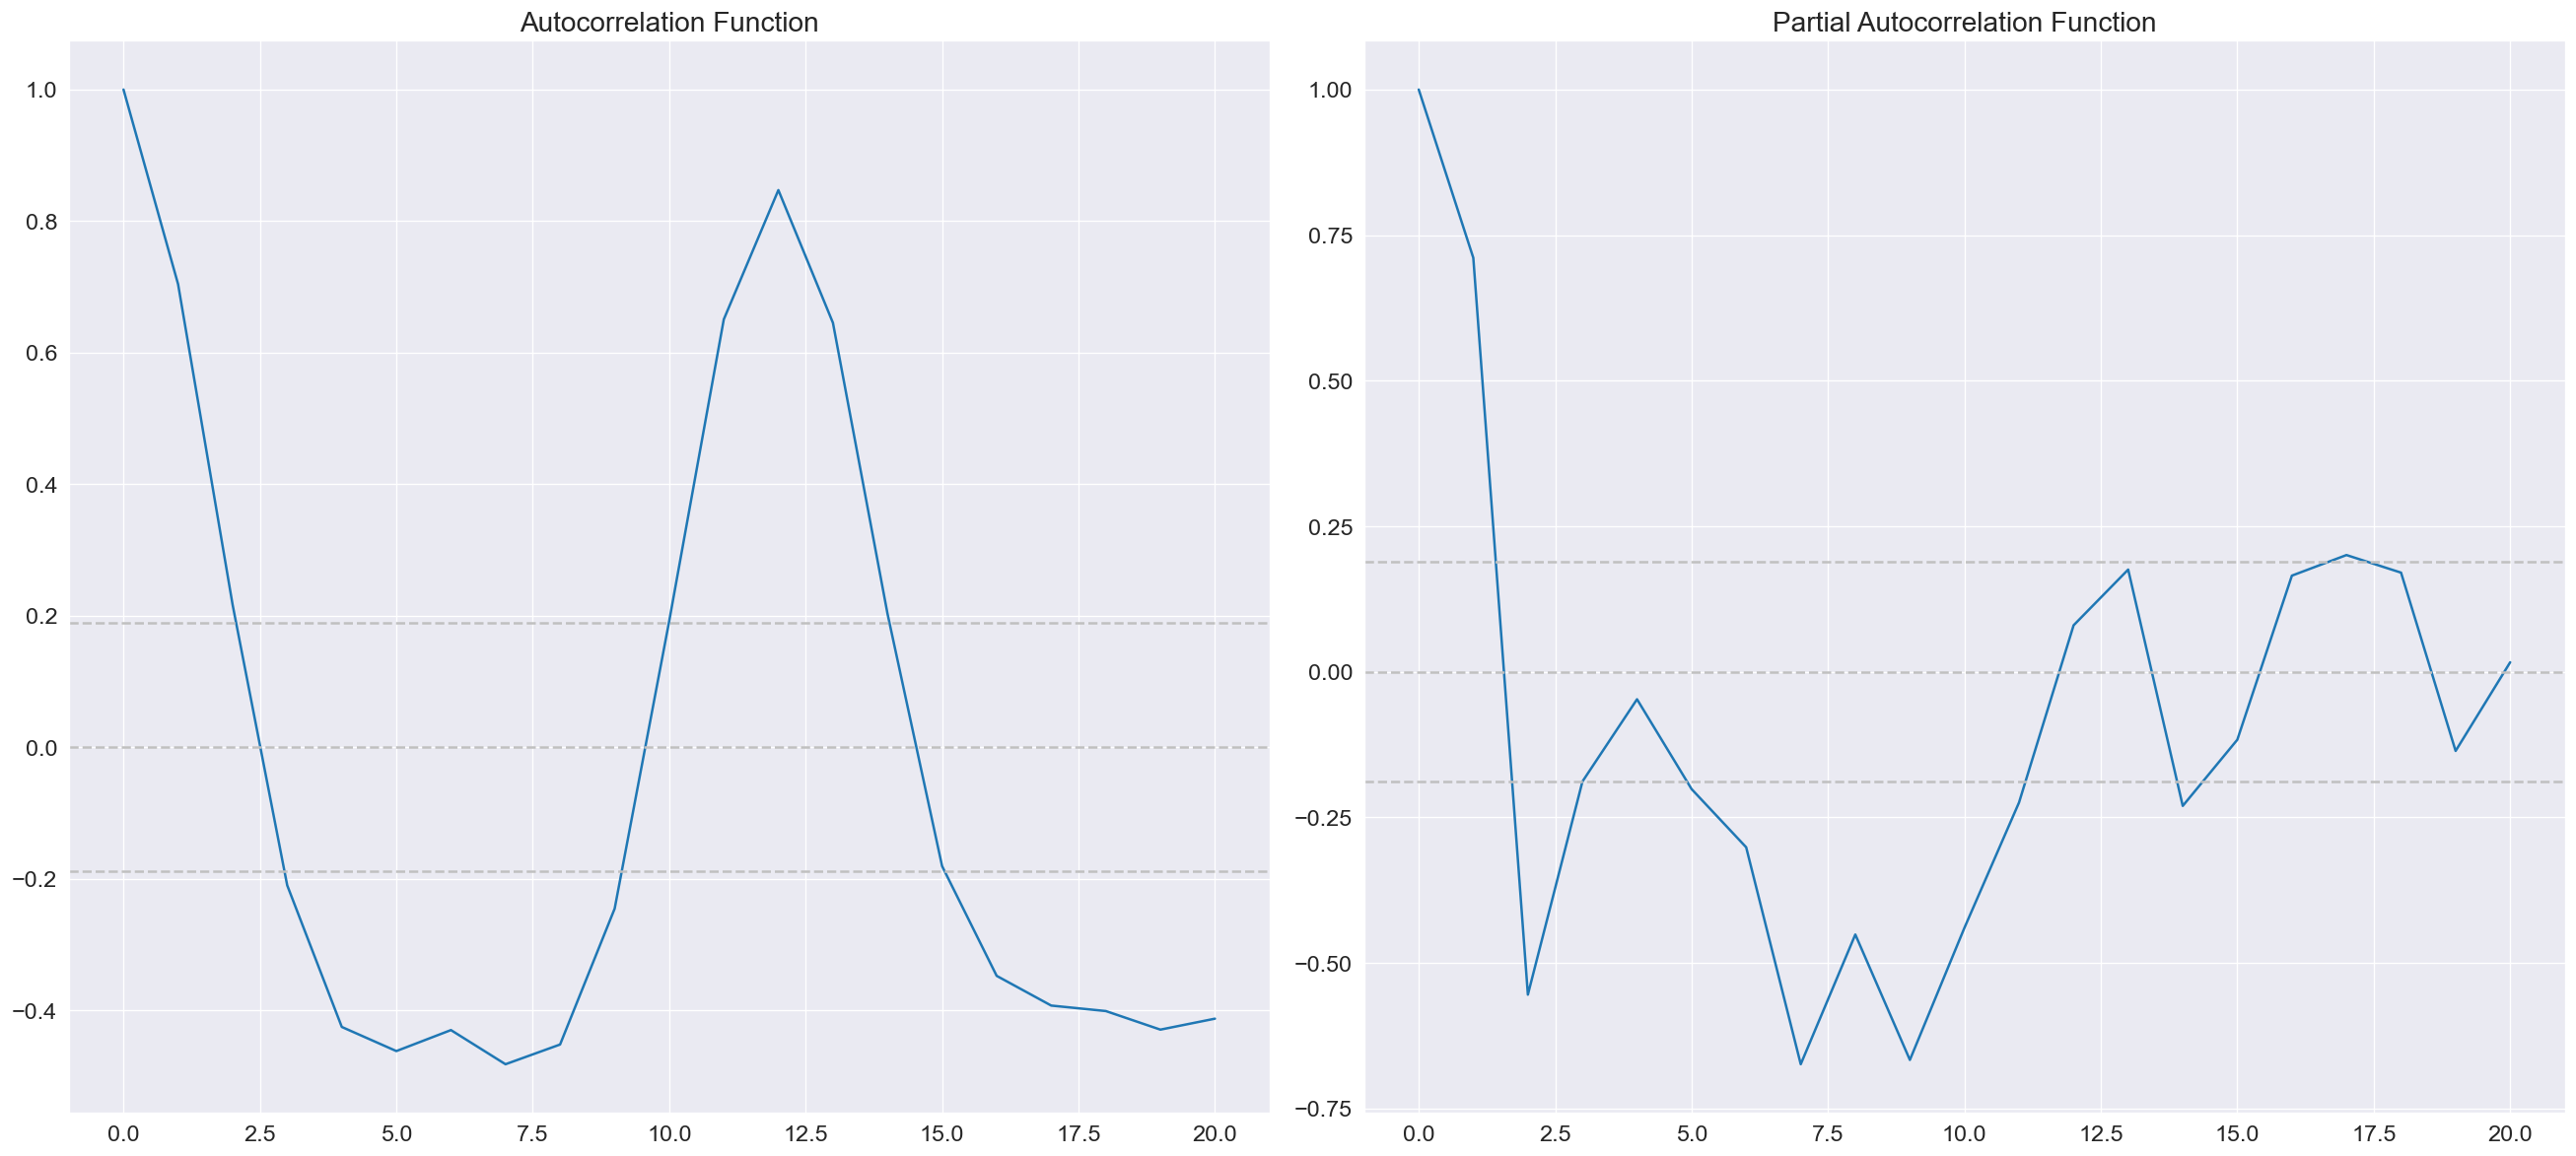

In [19]:
# Autocorrelation and partial autocorrelation plots

acf_lag = acf(train_df.diff().dropna().values, nlags=20)
pacf_lag = pacf(train_df.diff().dropna().values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

Feature Engineering

In [20]:
# Creating a new column 'tavg' which is the average of the 'tmin' and 'tmax columns'.
# 'tavg' stands for average temperature while 'tmin' and 'tmax' stands for minium and maximum temperature respectively.

data['avgtemp'] = (data['maxtempC']+data['mintempC'])/2
data['avgtemp']

date_time
2009-01-01 00:00:00    15.5
2009-01-01 01:00:00    15.5
2009-01-01 02:00:00    15.5
2009-01-01 03:00:00    15.5
2009-01-01 04:00:00    15.5
                       ... 
2020-01-01 19:00:00    14.5
2020-01-01 20:00:00    14.5
2020-01-01 21:00:00    14.5
2020-01-01 22:00:00    14.5
2020-01-01 23:00:00    14.5
Name: avgtemp, Length: 96432, dtype: float64

In [21]:
data.ffill(inplace=True)
data[data.isnull()].count()

date_time            0
maxtempC             0
mintempC             0
totalSnow_cm         0
sunHour              0
uvIndex              0
uvIndex.1            0
moon_illumination    0
moonrise             0
moonset              0
sunrise              0
sunset               0
DewPointC            0
FeelsLikeC           0
HeatIndexC           0
WindChillC           0
WindGustKmph         0
cloudcover           0
humidity             0
precipMM             0
pressure             0
tempC                0
visibility           0
winddirDegree        0
windspeedKmph        0
avgtemp              0
dtype: int64

In [22]:
# Removing unimportant columns from the dataset.

data = data.drop(['moonrise', 'moonset', 'sunrise', 'sunset', 'FeelsLikeC', 'totalSnow_cm', 'uvIndex.1'], axis=1)

In [23]:
# Creating new columns for year and month

data['Year'] = data['date_time'].dt.year
data['Month'] = data['date_time'].dt.month

In [24]:
# Replacing numbered months with their names to improve readability.

data['Month'] = data['Month'].replace([1,2,3,4,5,6,7,8,9,10,11,12], ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

In [25]:
data.head()

,date_time,maxtempC,mintempC,sunHour,uvIndex,moon_illumination,DewPointC,HeatIndexC,WindChillC,WindGustKmph,...,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,avgtemp,Year,Month
date_time,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,2009-01-01 00:00:00,22,9,8.7,4,31,4,14,14,19,...,50,0.0,1016,10,10,331,12,15.5,2009,January
2009-01-01 01:00:00,2009-01-01 01:00:00,22,9,8.7,4,31,4,14,13,21,...,51,0.0,1016,10,10,329,13,15.5,2009,January
2009-01-01 02:00:00,2009-01-01 02:00:00,22,9,8.7,4,31,4,13,12,22,...,52,0.0,1016,9,10,327,13,15.5,2009,January
2009-01-01 03:00:00,2009-01-01 03:00:00,22,9,8.7,4,31,4,13,11,23,...,54,0.0,1016,9,10,326,13,15.5,2009,January
2009-01-01 04:00:00,2009-01-01 04:00:00,22,9,8.7,4,31,3,13,11,21,...,52,0.0,1016,9,10,318,13,15.5,2009,January


In [26]:
#Omitting all the data from '2020' as there aren't many values to make valid assumptions

data = data[data['Year']!=2020]

In [27]:
data.to_csv('Raw.csv', index=True)

In [28]:
# Extracting all the different years from this dataset instance.

uniqueYear = data['Year'].unique()
print(uniqueYear)

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]


In [29]:
plot_array = np.array([data['Year'], data['precipMM']])

<Axes: xlabel='date_time', ylabel='precipMM'>

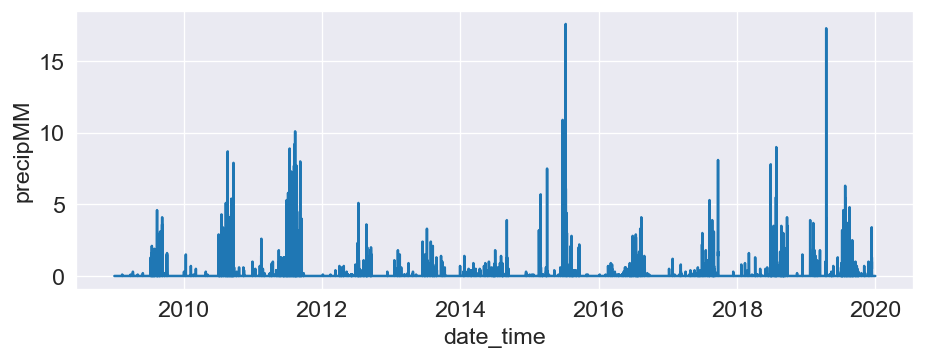

In [30]:
sns.lineplot(data=data, x="date_time", y="precipMM")

There does not seem to be any visible pattern here.

In [32]:
rain = []
visibility=[]
avgPrecip=[]
avgTemp=[]
nSunHour=[]
avgHumidity=[]
minTemp=[]
maxTemp=[]
heatIndex=[]

for i in range(len(uniqueYear)):
#     print(i)
    previous=uniqueYear[i]
    rain.append("%.2f" % data.loc[data['Year']==previous, 'precipMM'].sum())
    visibility.append("%.2f" % data.loc[data['Year']==previous, 'visibility'].mean())
    avgPrecip.append("%.2f" % data.loc[data['Year']==previous, 'precipMM'].mean())
    avgTemp.append("%.2f" % data.loc[data['Year']==previous, 'avgtemp'].mean())
    nSunHour.append("%.2f" % data.loc[data['Year']==previous, 'sunHour'].mean())
    avgHumidity.append("%.2f" % data.loc[data['Year']==previous, 'humidity'].mean())
    minTemp.append("%.2f" % data.loc[data['Year']==previous, 'mintempC'].mean())
    maxTemp.append("%.2f" % data.loc[data['Year']==previous, 'maxtempC'].mean())
    heatIndex.append("%.2f" % data.loc[data['Year']==previous, 'HeatIndexC'].mean())
#     new_df['netPrecipMM': float("%.2f" % raw.loc[raw['Year']==previous, 'precipMM'].sum())]
#     print("Precipitation in year " + str(previous) + ": " + str("%.2f" % raw.loc[raw['Year']==previous, 'precipMM'].sum()))

In [33]:
UniqueYear = pd.Series(uniqueYear)
Rain = pd.Series(rain)
Visibility = pd.Series(visibility)
AvgPrecip = pd.Series(avgPrecip)
AvgTemp = pd.Series(avgTemp)
SunHour = pd.Series(nSunHour)
AvgHumidity = pd.Series(avgHumidity)
MinTemp = pd.Series(minTemp)
MaxTemp = pd.Series(maxTemp)
HeatIndex = pd.Series(heatIndex)

d = {'Year': UniqueYear, 
     'Visibility': Visibility, 
     'PrecipMM': Rain, 
     'Average Precipitation': avgPrecip, 
     'Average Humidity': AvgHumidity, 
     'Minimum Temperature': MinTemp,
     'Average Temperature': AvgTemp, 
     'Maximum Temperature': MaxTemp, 
     'SunHour': SunHour, 
     'Heat Index': HeatIndex}

pd.DataFrame(data=d).to_csv('Extra.csv', index=False)

The above dataframe contains the average (sum in some cases) of the readings in the dataset.

In [34]:
precip_data = pd.read_csv('Extra.csv')
precip_data

,Year,Visibility,PrecipMM,Average Precipitation,Average Humidity,Minimum Temperature,Average Temperature,Maximum Temperature,SunHour,Heat Index
0,2009,9.84,175.8,0.02,43.09,19.82,26.55,33.29,11.32,30.60
1,2010,9.62,409.7,0.05,49.54,20.01,26.36,32.71,11.19,30.77
2,2011,9.70,550.5,0.06,51.27,19.32,25.28,31.25,11.16,29.73
3,2012,9.95,149.9,0.02,42.50,19.90,25.92,31.94,11.38,29.51
4,2013,9.95,111.8,0.01,43.02,20.66,26.46,32.27,11.31,29.89
5,2014,9.91,85.1,0.01,39.76,20.42,26.37,32.31,11.32,29.50
6,2015,9.92,281.7,0.03,38.45,21.68,26.92,32.16,11.20,30.14
7,2016,9.96,144.0,0.02,37.86,21.91,27.50,33.09,11.21,31.00
8,2017,9.95,150.2,0.02,35.20,22.68,27.92,33.17,11.27,31.23
9,2018,9.93,277.5,0.03,36.55,23.72,28.41,33.09,11.25,32.50


#### Visualising data through plots

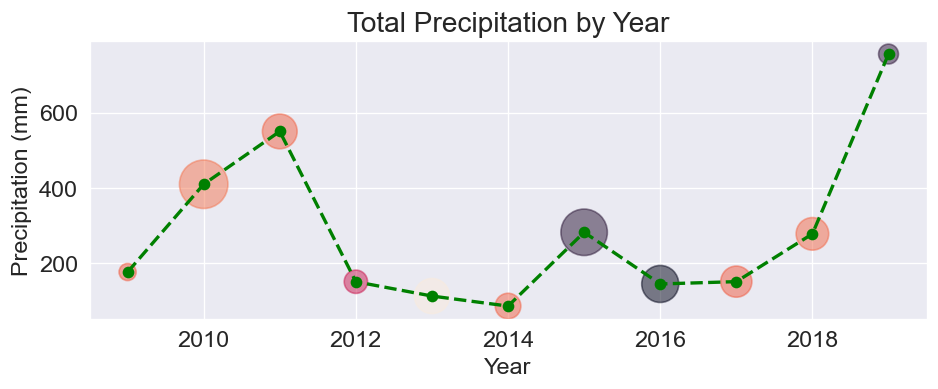

In [35]:
# Total Precipitation

np.random.seed(19680801)

N = 11
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

x=precip_data['Year']
y=precip_data['PrecipMM']

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.plot(x, y, 'go--', linewidth=2, markersize=6)
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('Total Precipitation by Year')
plt.show()

<Axes: xlabel='Year', ylabel='PrecipMM'>

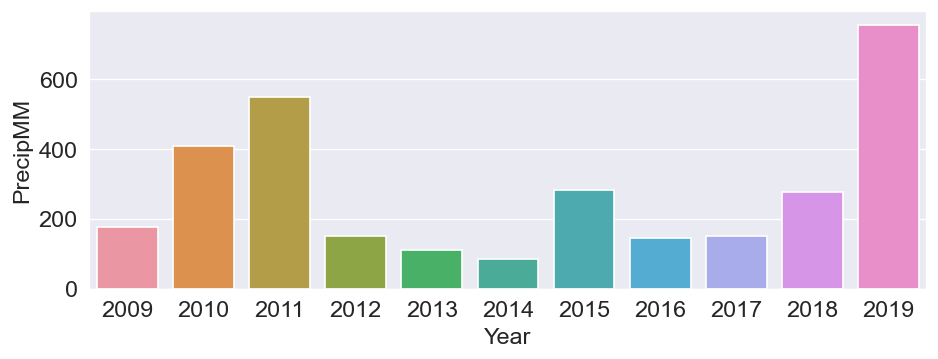

In [36]:
sns.barplot(data=precip_data, x="Year", y="PrecipMM")

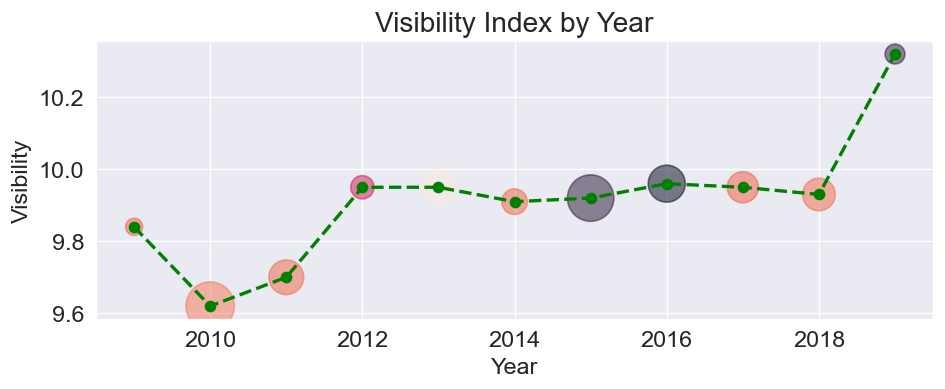

In [37]:
# Visibility Index

np.random.seed(19680801)

N = 11
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

x=precip_data['Year']
y=precip_data['Visibility']

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.plot(x, y, 'go--', linewidth=2, markersize=6)
plt.xlabel('Year')
plt.ylabel('Visibility')
plt.title('Visibility Index by Year')
plt.show()

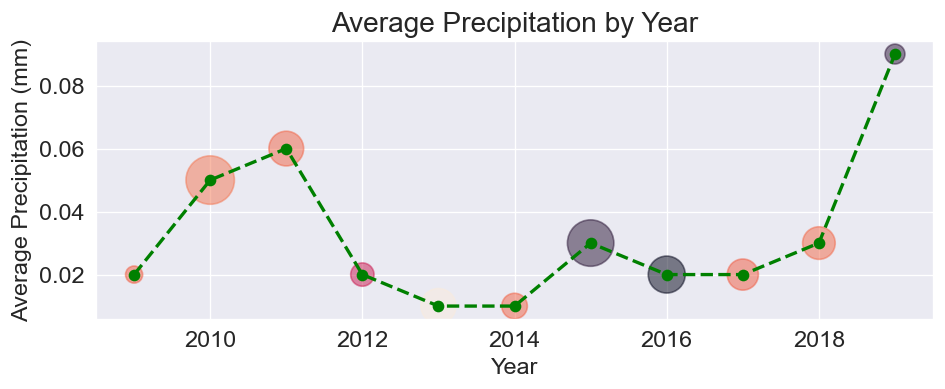

In [38]:
# Average Precipitation

np.random.seed(19680801)

N = 11
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

x=precip_data['Year']
y=precip_data['Average Precipitation']

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.plot(x, y, 'go--', linewidth=2, markersize=6)
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm)')
plt.title('Average Precipitation by Year')
plt.show()

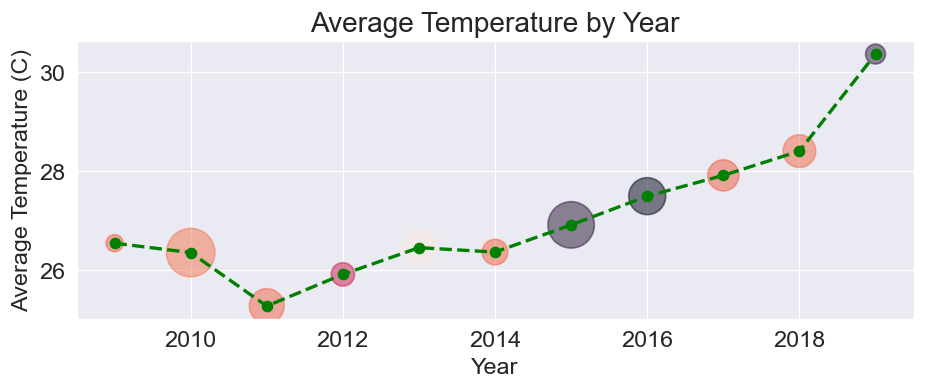

In [39]:
# Average Temperature

np.random.seed(19680801)

N = 11
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

x=precip_data['Year']
y=precip_data['Average Temperature']

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.plot(x, y, 'go--', linewidth=2, markersize=6)
plt.xlabel('Year')
plt.ylabel('Average Temperature (C)')
plt.title('Average Temperature by Year')
plt.show()

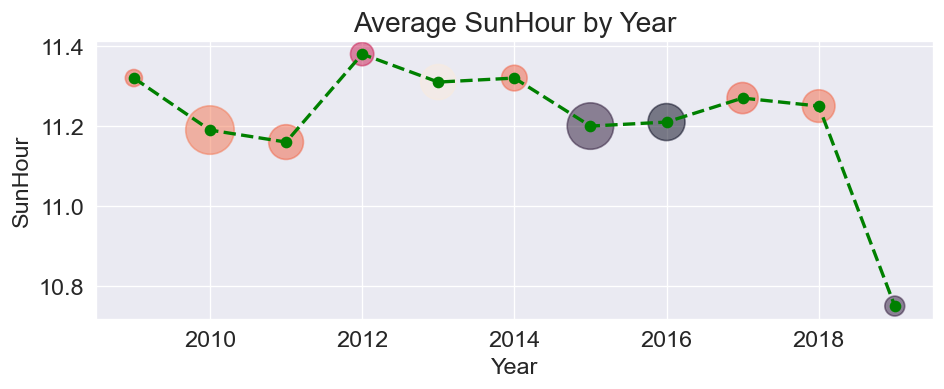

In [40]:
# Average SunHour

np.random.seed(19680801)

N = 11
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

x=precip_data['Year']
y=precip_data['SunHour']

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.plot(x, y, 'go--', linewidth=2, markersize=6)
plt.xlabel('Year')
plt.ylabel('SunHour')
plt.title('Average SunHour by Year')
plt.show()

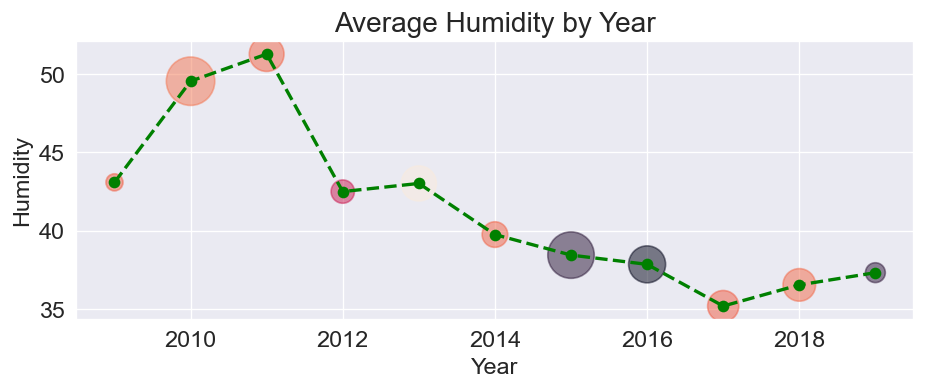

In [41]:
# Average Humidity

np.random.seed(19680801)

N = 11
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

x=precip_data['Year']
y=precip_data['Average Humidity']

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.plot(x, y, 'go--', linewidth=2, markersize=6)
plt.xlabel('Year')
plt.ylabel('Humidity')
plt.title('Average Humidity by Year')
plt.show()

In [42]:
df_alt = data[['sunHour', 'WindGustKmph', 'uvIndex', 'humidity', 'cloudcover', 'precipMM', 'pressure', 'visibility', 'avgtemp', 'Month', 'Year']]
df_alt.head()

,sunHour,WindGustKmph,uvIndex,humidity,cloudcover,precipMM,pressure,visibility,avgtemp,Month,Year
date_time,,,,,,,,,,,
2009-01-01 00:00:00,8.7,19,4,50,0,0.0,1016,10,15.5,January,2009
2009-01-01 01:00:00,8.7,21,4,51,0,0.0,1016,10,15.5,January,2009
2009-01-01 02:00:00,8.7,22,4,52,0,0.0,1016,10,15.5,January,2009
2009-01-01 03:00:00,8.7,23,4,54,0,0.0,1016,10,15.5,January,2009
2009-01-01 04:00:00,8.7,21,4,52,2,0.0,1016,10,15.5,January,2009


C:\Users\sande\AppData\Local\Temp\ipykernel_13208\1688700570.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_alt.corr().round(2), dtype=bool))
C:\Users\sande\AppData\Local\Temp\ipykernel_13208\1688700570.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df_alt.corr().round(2), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')


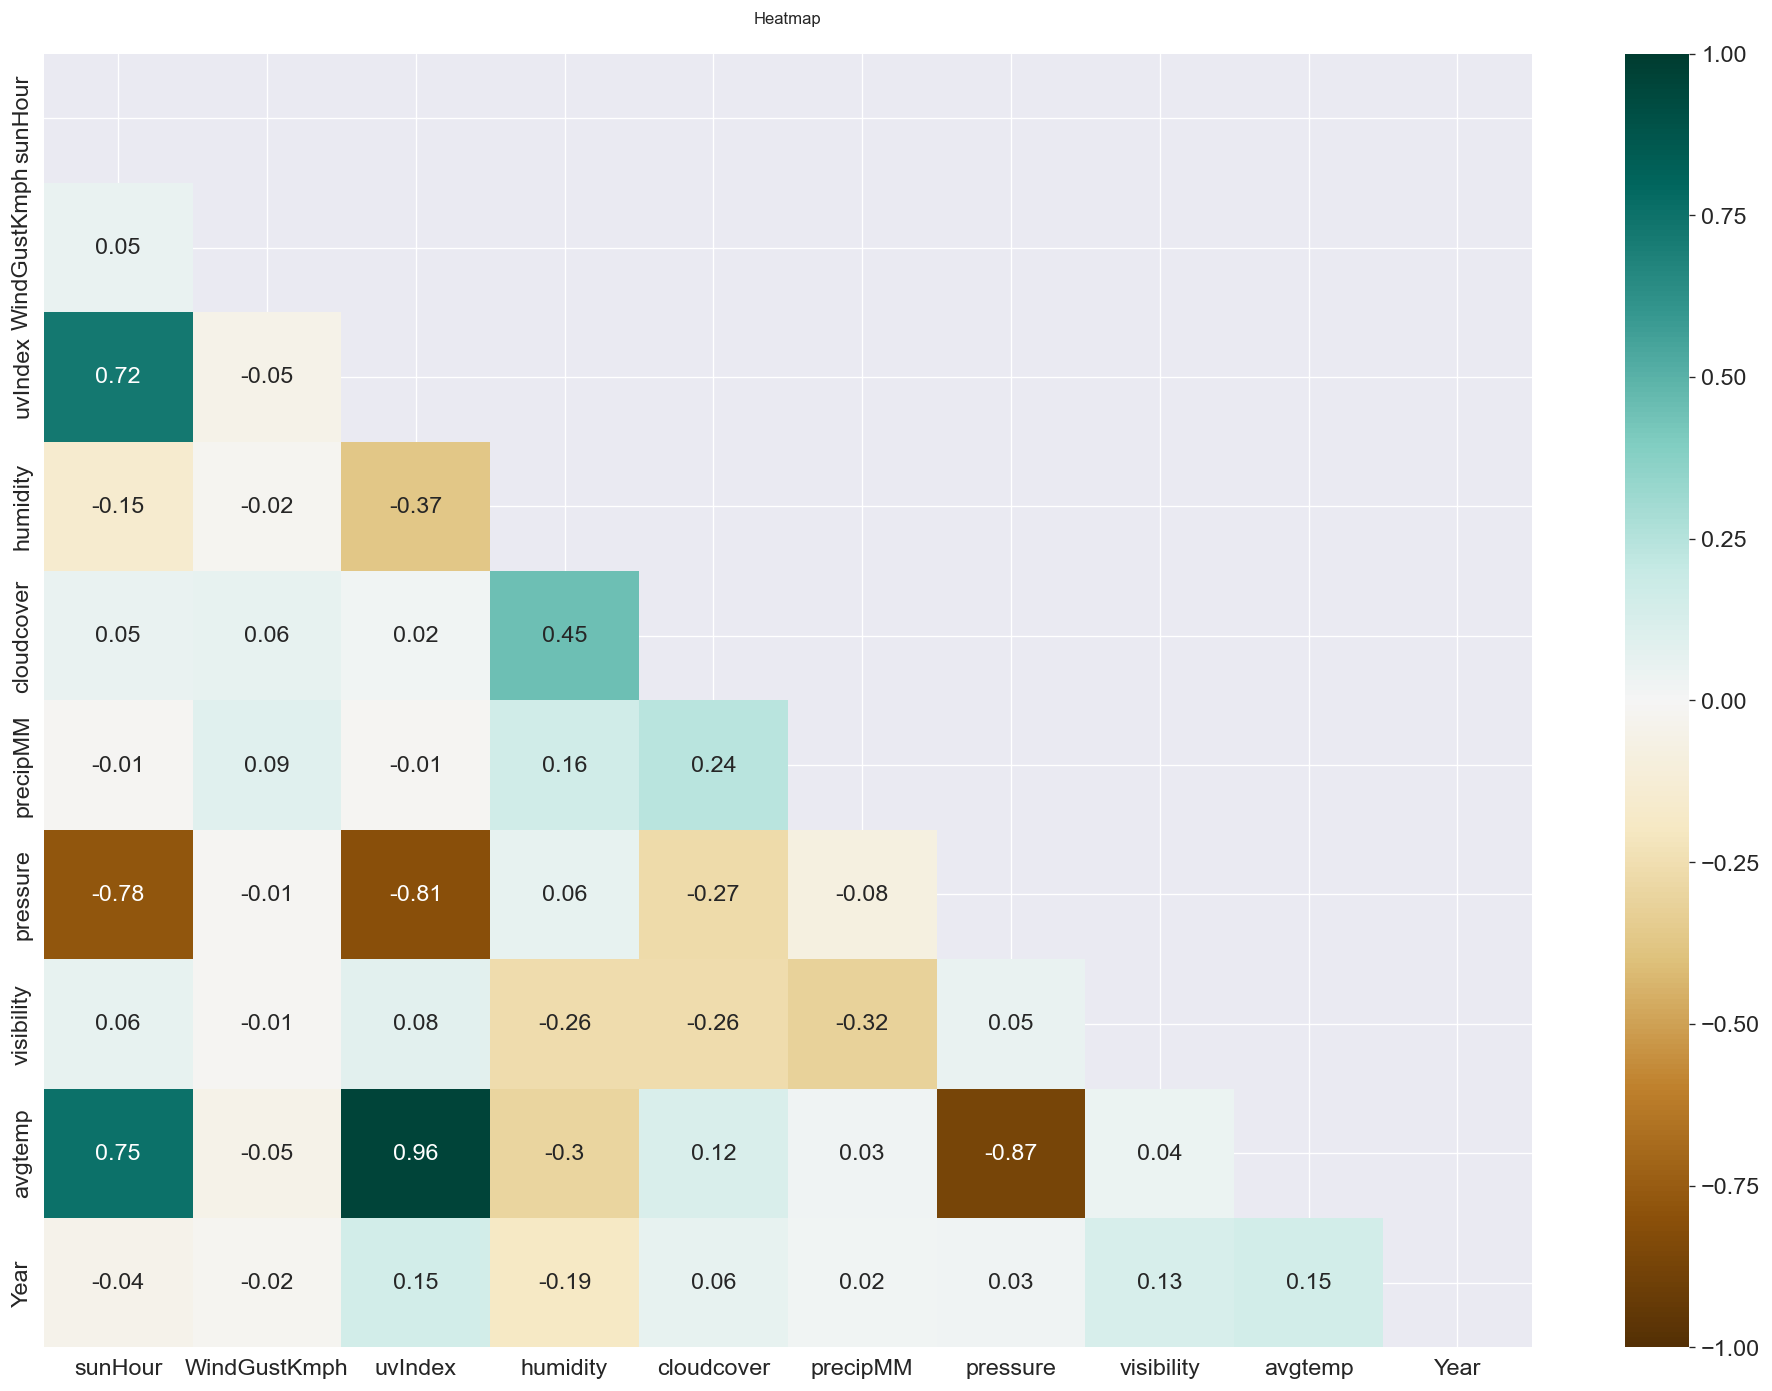

In [43]:
# Correlation Heatmap

plt.figure(figsize=(20, 14))
mask = np.triu(np.ones_like(df_alt.corr().round(2), dtype=bool))
heatmap = sns.heatmap(df_alt.corr().round(2), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Heatmap', fontdict={'fontsize':10}, pad=18);

In [44]:
train = df_alt[['sunHour', 'WindGustKmph', 'uvIndex', 'humidity', 'cloudcover', 'precipMM', 'pressure', 'visibility', 'avgtemp', 'Year']]

In [45]:
# Feature Importance

cv = KFold(n_splits=8, shuffle=True, random_state=1)

scorer = make_scorer(mean_squared_error, greater_is_better=False)

dataset = Dataset(
    df=train.sample(frac=0.4, random_state=1),
    target="precipMM",
    features=[col for col in train.columns if col != "precipMM"]
)

lgbm = LGBMRegressor(random_state=0, n_jobs=1)

lofo_imp = LOFOImportance(dataset, cv=cv, scoring=scorer, model=lgbm)

In [46]:
importance_df = lofo_imp.get_importance()

  0%|          | 0/9 [00:00<?, ?it/s]

In [47]:
importance_df

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3,val_imp_4,val_imp_5,val_imp_6,val_imp_7
3,visibility,0.021349,0.009091,0.041414,0.013184,0.008091,0.019027,0.021409,0.020489,0.023521,0.023654
7,humidity,0.002644,0.002124,0.004109,0.003377,-0.001548,0.000031,0.005094,0.002714,0.003045,0.004328
8,WindGustKmph,0.001092,0.001172,0.003154,0.002153,0.000776,0.000117,0.000805,-0.000566,0.002077,0.000215
2,Year,0.001051,0.000987,0.002216,0.000545,0.000208,0.001724,0.002309,-0.000753,0.001375,0.000781
1,sunHour,0.000868,0.001128,0.000558,0.002440,0.001308,-0.000257,-0.000833,-0.000117,0.002088,0.001758
0,uvIndex,0.000521,0.000805,-0.000332,0.001083,0.000358,0.001619,0.000271,-0.000965,0.001201,0.000933
6,cloudcover,0.000218,0.001331,0.001716,0.002003,0.000544,-0.000199,0.000457,0.000694,-0.002263,-0.001207
5,pressure,0.000098,0.001783,0.002369,0.001192,-0.000261,0.000012,0.002181,-0.003110,-0.001960,0.000363
4,avgtemp,-0.000002,0.001107,0.000037,-0.000941,0.002149,-0.000554,0.001501,-0.000508,-0.000966,-0.000738


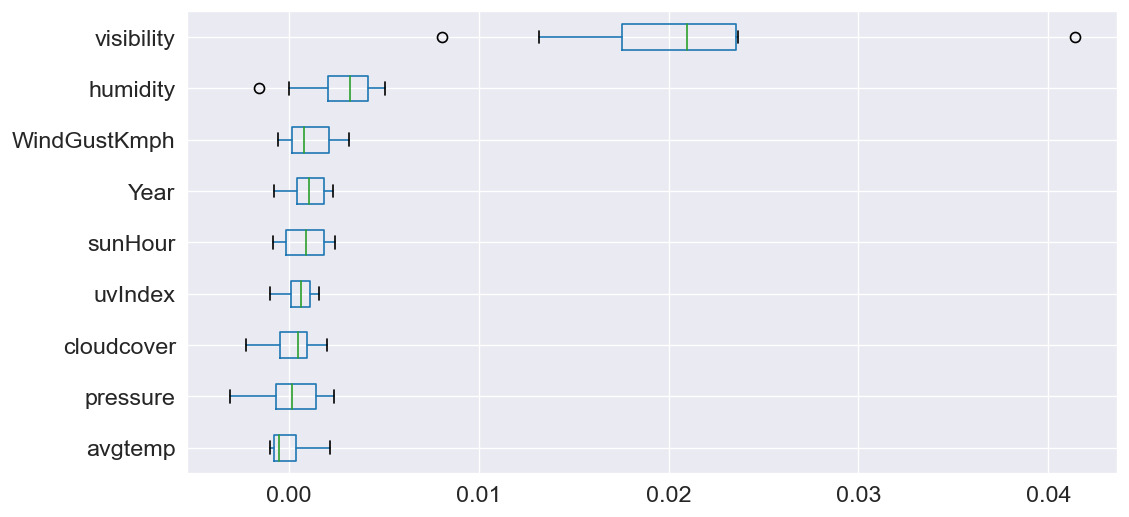

In [48]:
plot_importance(importance_df, figsize=(10, 5), kind="box")

Here, we can infer that 'visibility' and 'humidity' are two of the major factors affecting 'precipMM'.

Regression Model

In [49]:
train_inputs = (train[['visibility', 'humidity']]).iloc[:-1000]
train_targets = (train[['precipMM']]).iloc[:-1000]

print('Training Inputs: ' + str(train_inputs.shape))
print('Training Targets: ' + str(train_targets.shape))

Training Inputs: (95408, 2)
Training Targets: (95408, 1)


In [50]:
test_inputs = (train[['visibility', 'humidity']]).iloc[-1000:]
test_targets = (train[['precipMM']]).iloc[-1000:]

print('Testing Inputs: ' + str(test_inputs.shape))
print('Testing Targets: ' + str(test_targets.shape))

Testing Inputs: (1000, 2)
Testing Targets: (1000, 1)


In [51]:
model = LinearRegression()

In [52]:
model.fit(train_inputs, train_targets)

LinearRegression()

In [53]:
predictions = model.predict(test_inputs)
predictions[0:5]

array([[0.01316294],
       [0.01207469],
       [0.00880992],
       [0.00663341],
       [0.00445689]])

In [54]:
error = mean_squared_error(test_targets, predictions)
print(f"Error: {error}")

Error: 0.05800355706879528


#### SARIMAX Model

In [55]:
# stepwise_fit = auto_arima(train['precipMM'], trace=True, suppress_warnings=True)

# stepwise_fit.summary()

In [56]:
# Precipitation

model = ARIMA(train['precipMM'], order=(5,1,5))
model = model.fit()
print(model.summary())

C:\Users\sande\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\sande\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\sande\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\sande\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               precipMM   No. Observations:                96408
Model:                 ARIMA(5, 1, 5)   Log Likelihood               43947.116
Date:                Mon, 14 Aug 2023   AIC                         -87872.232
Time:                        03:56:28   BIC                         -87767.992
Sample:                    01-01-2009   HQIC                        -87840.545
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6859      0.005    142.594      0.000       0.677       0.695
ar.L2         -0.5991      0.004   -137.177      0.000      -0.608      -0.591
ar.L3          0.2822      0.003     83.223      0.0

In [57]:
# Making seperate data for training and testing. Last 1000 tuples are for testing purpose.

train_train = train.iloc[:-1000]
test_train = train.iloc[-1000:]

print("Train: " + str(train_train.shape))
print("Test: " + str(test_train.shape))

Train: (95408, 10)
Test: (1000, 10)


In [58]:
# Predicting for the last 1000 tuples now.

start = len(train_train)
end = len(train_train)+len(test_train)-1
pred = pd.Series(model.predict(start=start, end=end, type='levels'))
print(pred)
pred.index=train.index[start:end+1]

2019-11-20 08:00:00    0.000329
2019-11-20 09:00:00    0.000326
2019-11-20 10:00:00    0.000323
2019-11-20 11:00:00    0.000319
2019-11-20 12:00:00    0.000316
                         ...   
2019-12-31 19:00:00    0.000964
2019-12-31 20:00:00    0.000954
2019-12-31 21:00:00    0.000945
2019-12-31 22:00:00    0.000935
2019-12-31 23:00:00    0.000926
Freq: H, Name: predicted_mean, Length: 1000, dtype: float64


<Axes: xlabel='date_time'>

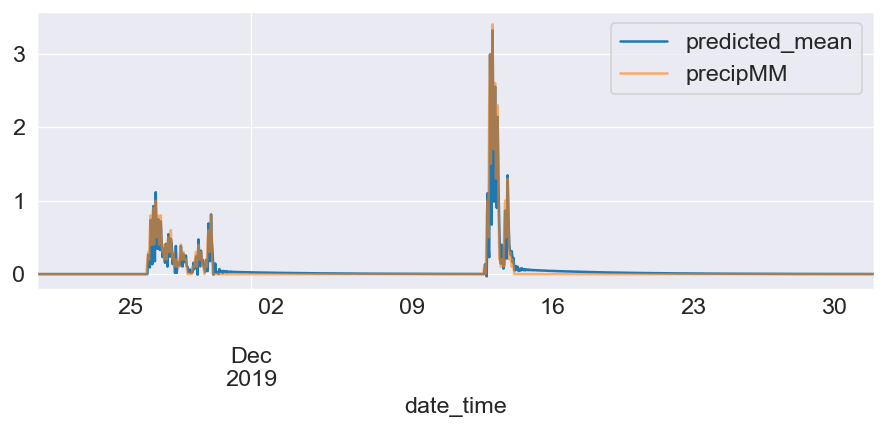

In [59]:
# Plotting the predicted values against the actual values to visualise the accuracy of our model.

pred.plot(legend=True)
(test_train['precipMM'].plot(alpha=0.6, legend=True))

In [60]:
error = mean_squared_error(test_train.precipMM, pred)
print(f"Error: {error}")

Error: 0.01433997745570959


We can see that the error is reduced by about 5 times in the SARIMAX model as compared to the simple linear regression model.

Now, we will check the results for different test sizes- 2000, 3000 and 4000 tuples for test data.

In [61]:
# 2000 tuples

train_train = train.iloc[:-2000]
test_train = train.iloc[-2000:]

print("Train: " + str(train_train.shape))
print("Test: " + str(test_train.shape))

Train: (94408, 10)
Test: (2000, 10)


In [62]:
# Predicting for the last 2000 tuples now.

start = len(train_train)
end = len(train_train)+len(test_train)-1
pred = pd.Series(model.predict(start=start, end=end, type='levels'))
print(pred)
pred.index=train.index[start:end+1]

2019-10-09 16:00:00    0.002365
2019-10-09 17:00:00    0.002341
2019-10-09 18:00:00    0.002318
2019-10-09 19:00:00    0.002295
2019-10-09 20:00:00    0.002272
                         ...   
2019-12-31 19:00:00    0.000964
2019-12-31 20:00:00    0.000954
2019-12-31 21:00:00    0.000945
2019-12-31 22:00:00    0.000935
2019-12-31 23:00:00    0.000926
Freq: H, Name: predicted_mean, Length: 2000, dtype: float64


<Axes: xlabel='date_time'>

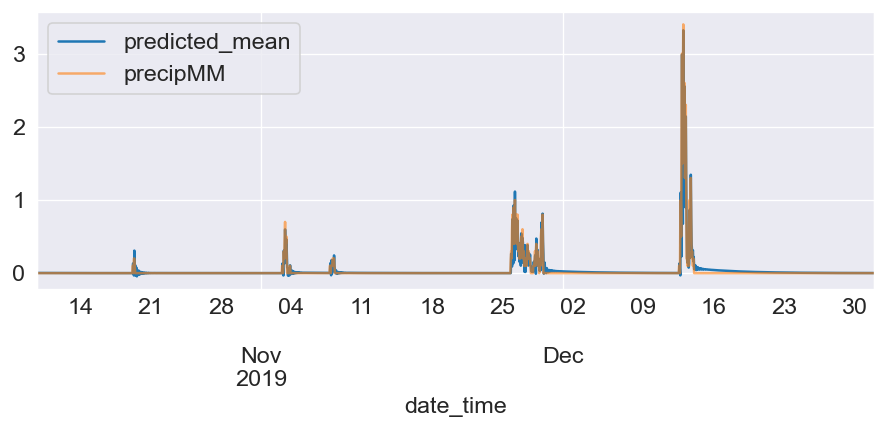

In [63]:
# Plotting the predicted values against the actual values to visualise the accuracy of our model.

pred.plot(legend=True)
(test_train['precipMM'].plot(alpha=0.6, legend=True))

In [64]:
error = mean_squared_error(test_train.precipMM, pred)
print(f"Error: {error}")

Error: 0.007430393373934703


In [65]:
# 3000 tuples

train_train = train.iloc[:-3000]
test_train = train.iloc[-3000:]

print("Train: " + str(train_train.shape))
print("Test: " + str(test_train.shape))

Train: (93408, 10)
Test: (3000, 10)


In [66]:
# Predicting for the last 3000 tuples now.

start = len(train_train)
end = len(train_train)+len(test_train)-1
pred = pd.Series(model.predict(start=start, end=end, type='levels'))
print(pred)
pred.index=train.index[start:end+1]

2019-08-29 00:00:00    0.028266
2019-08-29 01:00:00    0.024686
2019-08-29 02:00:00    0.002645
2019-08-29 03:00:00    0.035148
2019-08-29 04:00:00    0.008198
                         ...   
2019-12-31 19:00:00    0.000964
2019-12-31 20:00:00    0.000954
2019-12-31 21:00:00    0.000945
2019-12-31 22:00:00    0.000935
2019-12-31 23:00:00    0.000926
Freq: H, Name: predicted_mean, Length: 3000, dtype: float64


<Axes: xlabel='date_time'>

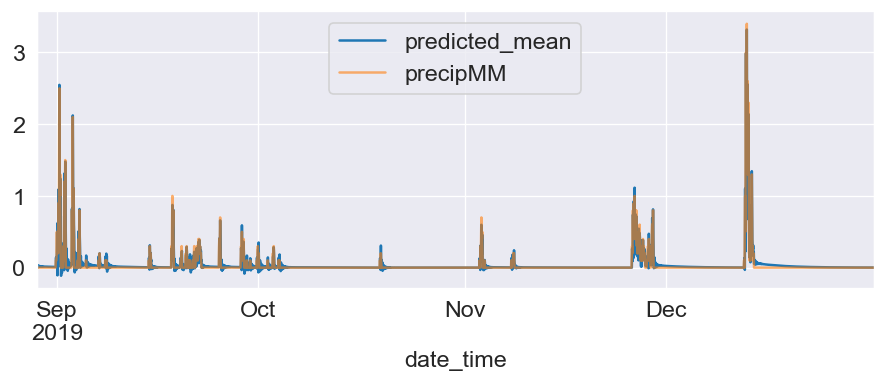

In [67]:
# Plotting the predicted values against the actual values to visualise the accuracy of our model.

pred.plot(legend=True)
(test_train['precipMM'].plot(alpha=0.6, legend=True))

In [68]:
error = mean_squared_error(test_train.precipMM, pred)
print(f"Error: {error}")

Error: 0.009056916476972257


In [69]:
# 4000 tuples

train_train = train.iloc[:-4000]
test_train = train.iloc[-4000:]

print("Train: " + str(train_train.shape))
print("Test: " + str(test_train.shape))

Train: (92408, 10)
Test: (4000, 10)


In [70]:
# Predicting for the last 4000 tuples now.

start = len(train_train)
end = len(train_train)+len(test_train)-1
pred = pd.Series(model.predict(start=start, end=end, type='levels'))
print(pred)
pred.index=train.index[start:end+1]

2019-07-18 08:00:00    0.361221
2019-07-18 09:00:00    0.436926
2019-07-18 10:00:00    0.434834
2019-07-18 11:00:00    0.262017
2019-07-18 12:00:00    0.143640
                         ...   
2019-12-31 19:00:00    0.000964
2019-12-31 20:00:00    0.000954
2019-12-31 21:00:00    0.000945
2019-12-31 22:00:00    0.000935
2019-12-31 23:00:00    0.000926
Freq: H, Name: predicted_mean, Length: 4000, dtype: float64


<Axes: xlabel='date_time'>

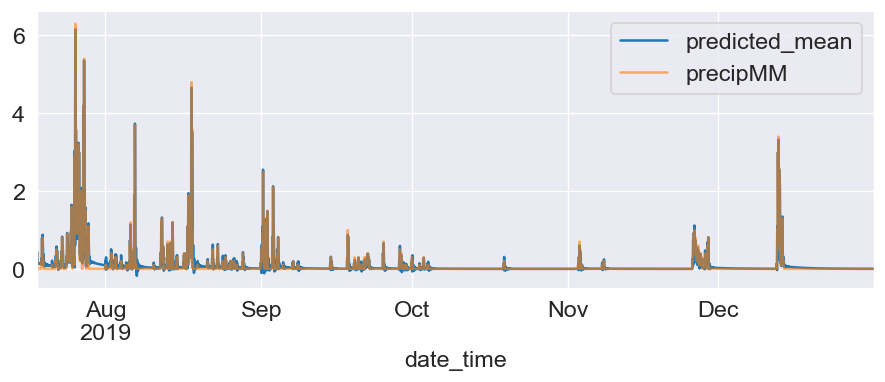

In [71]:
# Plotting the predicted values against the actual values to visualise the accuracy of our model.

pred.plot(legend=True)
(test_train['precipMM'].plot(alpha=0.6, legend=True))

In [72]:
error = mean_squared_error(test_train.precipMM, pred)
print(f"Error: {error}")

Error: 0.030685373977265874


As, we can see that the error decreased when we increased the test data size from 1000 tuples to 2000.
However, upon further increasing the size of the test data the error increased significantly overtaking the error at 1000 tuples.
This observation implies that the increased size of the test data decreases the accuracy of the trained model.

Now, let's test this hypothesis with 5000 tuples.

In [73]:
# 5000 tuples

train_train = train.iloc[:-5000]
test_train = train.iloc[-5000:]

print("Train: " + str(train_train.shape))
print("Test: " + str(test_train.shape))

Train: (91408, 10)
Test: (5000, 10)


In [74]:
# Predicting for the last 5000 tuples now.

start = len(train_train)
end = len(train_train)+len(test_train)-1
pred = pd.Series(model.predict(start=start, end=end, type='levels'))
print(pred)
pred.index=train.index[start:end+1]

2019-06-06 16:00:00    0.000549
2019-06-06 17:00:00    0.000544
2019-06-06 18:00:00    0.000538
2019-06-06 19:00:00    0.000533
2019-06-06 20:00:00    0.000528
                         ...   
2019-12-31 19:00:00    0.000964
2019-12-31 20:00:00    0.000954
2019-12-31 21:00:00    0.000945
2019-12-31 22:00:00    0.000935
2019-12-31 23:00:00    0.000926
Freq: H, Name: predicted_mean, Length: 5000, dtype: float64


<Axes: xlabel='date_time'>

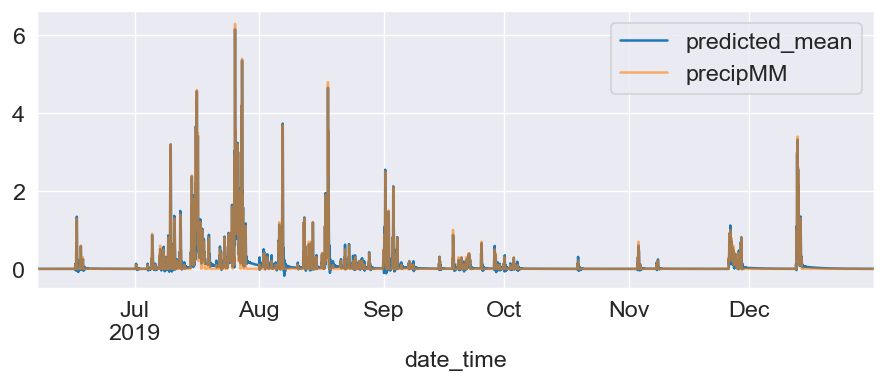

In [75]:
# Plotting the predicted values against the actual values to visualise the accuracy of our model.

pred.plot(legend=True)
(test_train['precipMM'].plot(alpha=0.6, legend=True))

In [76]:
error = mean_squared_error(test_train.precipMM, pred)
print(f"Error: {error}")

Error: 0.032995134188055684


As we can see that the error further increased from 0.0307 to 0.033. This proves our earlier hypothesis.

### Saving the model.

In [79]:
model.save('./predictWeatherModel.pkl')